In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math


pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

## Reading data

In [2]:
df_transactions = pd.read_csv('data/transactions.csv')
df_demographics = pd.read_csv('data/demographics.csv')
df_products = pd.read_csv('data/products.csv')
# old_promotions = pd.read_csv('time_on_app.csv')
df_promotions = pd.read_csv('data/promotions.csv')
df_campaigns = pd.read_csv('data/campaigns.csv')

In [3]:
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,98,782443249,0.39,1.0,0.00
1,1,1,98,3112548822,3.00,2.0,-0.08
2,1,1,98,6571651611,1.15,4.0,0.00
3,1,1,98,8840487053,1.25,1.0,-0.34
4,1,1,212,782443249,0.65,1.0,0.00


In [4]:
df_promotions.sort_values(['HOUSEHOLD_KEY','WEEK_NO']).head()

,WEEK_NO,HOUSEHOLD_KEY,TIME_IN_APP,NUM_COUPONS
0,1,1,11,0
801,2,1,11,0
1602,3,1,11,0
2403,4,1,11,0
3204,5,1,11,0


In [5]:
households = df_transactions['HOUSEHOLD_KEY'].sort_values().unique()
max_week = df_transactions['WEEK_NO'].max()

big_df = pd.DataFrame()

for key in households:
    df = pd.DataFrame()
    df['WEEK_NO'] = np.arange(1,max_week+1)
    df['HOUSEHOLD_KEY'] = key
    
    big_df = pd.concat([big_df,df])

print(big_df.shape)
big_df.head()

(81702, 2)


,WEEK_NO,HOUSEHOLD_KEY
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


# Adding time information: month, weekday, season

In [6]:
spring_summer_products = df_products[df_products['COMMODITY_DESC']=='SPRING/SUMMER SEASONAL']['PRODUCT_ID'].to_list()
fall_winter_products = df_products[df_products['COMMODITY_DESC']=='FALL AND WINTER SEASONAL']['PRODUCT_ID'].to_list()
christmas_products = df_products[df_products['COMMODITY_DESC'].str.contains('CHRISTMAS')]['PRODUCT_ID'].to_list()

spring_summer = df_transactions[df_transactions['PRODUCT_ID'].isin(spring_summer_products)]
fall_winter = df_transactions[df_transactions['PRODUCT_ID'].isin(fall_winter_products)]
christmas = df_transactions[df_transactions['PRODUCT_ID'].isin(christmas_products)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


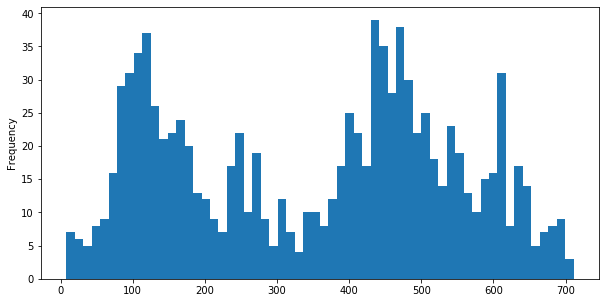

In [7]:
spring_summer['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


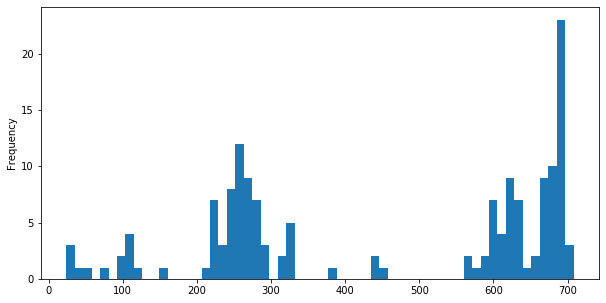

In [8]:
fall_winter['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


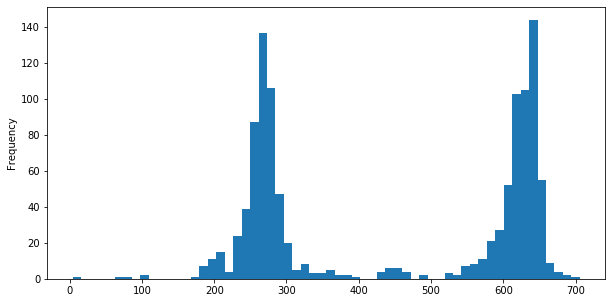

In [9]:
christmas['DAY'].plot('hist', bins=60, figsize=(10,5))

In [10]:
def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February', 2
    elif day_number<40:
        return 'March', 3
    elif day_number<70:
        return 'April', 4
    elif day_number<100:
        return 'May', 5
    elif day_number<130:
        return 'June', 6
    elif day_number<160:
        return 'July', 7
    elif day_number<190:
        return 'August', 8
    elif day_number<220:
        return 'September', 9
    elif day_number<250:
        return 'October', 10
    elif day_number<280:
        return 'November', 11
    elif day_number<310:
        return 'December', 12
    elif day_number<340:
        return 'January', 1

df_transactions['month'], df_transactions['month_num'] = zip(*df_transactions['DAY'].apply(add_month_names))


def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday', day_number+1
    elif day_number==2:
        return 'Wednesday', day_number+1
    elif day_number==3:
        return 'Thursday', day_number+1
    elif day_number==4:
        return 'Friday', day_number+1
    elif day_number==5:
        return 'Saturday', day_number+1
    elif day_number==6:
        return 'Sunday', day_number+1
    elif day_number==0:
        return 'Monday', day_number+1
    
df_transactions['weekday'],df_transactions['weekday_num'] = zip(*df_transactions['DAY'].apply(add_week_day_names))


def get_season(month):
    if month == 'December' or month == 'January' or month == 'February':
        return 'winter'
    elif month == 'March' or month == 'April' or month == 'May':
        return 'spring'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'summer'
    elif month == 'September' or month == 'October' or month == 'November':
        return 'fall'
    
df_transactions['season'] = df_transactions['month'].apply(get_season)



In [11]:
week_month_lookup = df_transactions[['DAY','WEEK_NO','month_num']].drop_duplicates().reset_index().drop('index',axis=1)
week_month_lookup.drop('DAY', axis=1, inplace=True)
week_month_lookup.drop_duplicates(subset=['WEEK_NO'], keep="first", inplace=True)

print(week_month_lookup.shape)
week_month_lookup.head(10)

(102, 2)


,WEEK_NO,month_num
0,1,2
5,2,2
12,3,3
19,4,3
26,5,3
33,6,3
40,7,4
47,8,4
54,9,4
61,10,4


In [12]:
week_month_season_lookup = week_month_lookup.merge(df_transactions[['WEEK_NO','month_num','month','season']].drop_duplicates(), on=['WEEK_NO','month_num'], how='left')
print(week_month_season_lookup.shape)
week_month_season_lookup.head()


(102, 4)


,WEEK_NO,month_num,month,season
0,1,2,February,winter
1,2,2,February,winter
2,3,3,March,spring
3,4,3,March,spring
4,5,3,March,spring


## 2 merge with product table

In [13]:
things_families_buy = df_transactions[['HOUSEHOLD_KEY','PRODUCT_ID']].merge(df_products, on='PRODUCT_ID', how='left')

things_families_buy = things_families_buy[['HOUSEHOLD_KEY','DEPARTMENT','COMMODITY_DESC']]
things_families_buy.sort_values(by='HOUSEHOLD_KEY').head()

things_families_buy.head()



,HOUSEHOLD_KEY,DEPARTMENT,COMMODITY_DESC
0,98,PRODUCE,TROPICAL FRUIT
1,98,GROCERY,COOKIES/CONES
2,98,GROCERY,BAG SNACKS
3,98,GROCERY,BAKED SWEET GOODS
4,212,PRODUCE,TROPICAL FRUIT


In [14]:
most_popular_department = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_department = most_popular_department.groupby('DEPARTMENT').size().reset_index()
most_popular_department.rename(columns={0:'count'}, inplace=True)
most_popular_department = most_popular_department.sort_values('count', ascending=False)
most_popular_department_list = most_popular_department.head()['DEPARTMENT'].tolist()
most_popular_department_list

['GROCERY', 'PRODUCE', 'DRUG GM', 'MEAT-PCKGD', 'MEAT']

In [15]:
most_popular_commodity = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_commodity = most_popular_commodity.groupby('COMMODITY_DESC').size().reset_index()
most_popular_commodity.rename(columns={0:'count'}, inplace=True)
most_popular_commodity = most_popular_commodity.sort_values('count', ascending=False)
most_popular_commodity_list = most_popular_commodity.head()['COMMODITY_DESC'].tolist()
most_popular_commodity_list

['FLUID MILK PRODUCTS',
 'SOFT DRINKS',
 'BAKED BREAD/BUNS/ROLLS',
 'CHEESE',
 'BAG SNACKS']

In [16]:
most_popular_department_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','DEPARTMENT']).size().reset_index()
most_popular_department_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_department_per_family_reduced = most_popular_department_per_family[most_popular_department_per_family['DEPARTMENT'].isin(most_popular_department_list)]

most_popular_department_per_family_reduced.head()


,HOUSEHOLD_KEY,DEPARTMENT,count
1,1,DRUG GM,120
3,1,GROCERY,856
4,1,MEAT,4
5,1,MEAT-PCKGD,91
10,1,PRODUCE,152


In [17]:
popular_department_table = most_popular_department_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'DEPARTMENT', values='count')
popular_department_table.columns.name = None

popular_department_table.fillna(0, inplace=True)
popular_department_table = popular_department_table.reset_index()

popular_department_table.head()


,HOUSEHOLD_KEY,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE
0,1,120.0,856.0,4.0,91.0,152.0
1,7,115.0,569.0,35.0,23.0,117.0
2,8,148.0,844.0,52.0,64.0,147.0
3,13,290.0,1059.0,1.0,74.0,109.0
4,16,31.0,303.0,15.0,17.0,42.0


In [18]:
most_popular_commodity_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','COMMODITY_DESC']).size().reset_index()
most_popular_commodity_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_commodity_per_family_reduced = most_popular_commodity_per_family[most_popular_commodity_per_family['COMMODITY_DESC'].isin(most_popular_commodity_list)]

most_popular_commodity_per_family_reduced.head()


,HOUSEHOLD_KEY,COMMODITY_DESC,count
4,1,BAG SNACKS,43
5,1,BAKED BREAD/BUNS/ROLLS,61
21,1,CHEESE,38
55,1,FLUID MILK PRODUCTS,40
113,1,SOFT DRINKS,29


In [19]:
popular_commodity_table = most_popular_commodity_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'COMMODITY_DESC', values='count')
popular_commodity_table.columns.name = None

popular_commodity_table.fillna(0, inplace=True)
popular_commodity_table = popular_commodity_table.reset_index()

popular_commodity_table.head()


,HOUSEHOLD_KEY,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS
0,1,43.0,61.0,38.0,40.0,29.0
1,7,18.0,27.0,23.0,23.0,12.0
2,8,18.0,44.0,42.0,42.0,29.0
3,13,31.0,35.0,43.0,102.0,33.0
4,16,10.0,68.0,5.0,45.0,5.0


## aggregate by day

In [20]:
daily_transactions = df_transactions.groupby(["HOUSEHOLD_KEY", "DAY",'WEEK_NO'])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
daily_transactions.head()


,HOUSEHOLD_KEY,DAY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,51,8,78.66,34.0,-16.54
1,1,67,10,41.10,14.0,-8.59
2,1,88,13,26.90,13.0,-6.72
3,1,94,14,63.43,32.0,-11.58
4,1,101,15,53.45,20.0,-16.42


In [21]:
daily_transactions['last_shopping_day'] = daily_transactions.groupby('HOUSEHOLD_KEY')['DAY'].shift(1)
daily_transactions['days_since_shopping'] = daily_transactions['DAY']-daily_transactions['last_shopping_day']
daily_transactions = daily_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO','days_since_shopping']]
daily_transactions.head(400)

,HOUSEHOLD_KEY,DAY,WEEK_NO,days_since_shopping
0,1,51,8,NaN
1,1,67,10,16.0
2,1,88,13,21.0
3,1,94,14,6.0
4,1,101,15,7.0
5,1,108,16,7.0
6,1,111,17,3.0
7,1,128,19,17.0
8,1,137,20,9.0
9,1,146,22,9.0


In [22]:
# WE ARE GOING TO NEED IT IN WEEK FORMAT

# keep last
# previous_visit_day = daily_transactions.drop_duplicates(subset=['HOUSEHOLD_KEY','WEEK_NO'], keep="last")
# previous_visit_day.drop('DAY', axis=1, inplace=True)
# previous_visit_day.head()

# keep average
previous_visit_day = daily_transactions.groupby(['HOUSEHOLD_KEY','WEEK_NO']).mean().reset_index()
previous_visit_day.drop('DAY', axis=1, inplace=True)
previous_visit_day.head()


,HOUSEHOLD_KEY,WEEK_NO,days_since_shopping
0,1,8,NaN
1,1,10,16.0
2,1,13,21.0
3,1,14,6.0
4,1,15,7.0


In [23]:
def fill_nas_for_last_day(days_since_shopping):

    new_column = []
    days_since_column = days_since_shopping.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(days_since_column)):
        num_weeks = 1
        value = days_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(days_since_column):
                next_day_since_value = days_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(days_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = days_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= 7*num_weeks:
                    value = next_day_since_value-7*num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=days_since_shopping.index)


In [24]:
a = big_df.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
a['days_since_last_shopping'] = a.groupby('HOUSEHOLD_KEY')['days_since_shopping'].apply(fill_nas_for_last_day)

In [25]:
previous_visit_day = a[['HOUSEHOLD_KEY', 'WEEK_NO', 'days_since_last_shopping']].copy()
print(previous_visit_day.shape)
previous_visit_day.head(20)

(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,days_since_last_shopping
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,2.0
8,1,9,9.0
9,1,10,16.0


In [26]:
previous_visit_day.isna().sum()

HOUSEHOLD_KEY                   0
WEEK_NO                         0
days_since_last_shopping    11150
dtype: int64

In [27]:
# df_transactions = df_transactions.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
# df_transactions.head()

## aggregate to weekly

In [93]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [94]:
# we'll add this feature a bit later in the notebook
# transactions_weekly_aggregated['prev_amount'] = transactions_weekly_aggregated['SALES_VALUE'].shift(1)

In [95]:
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [31]:
# # we need to generate the fake variable here and save it before the training

# from random import randint
# import numpy as np


# #time spent on the app's discount section
# data = transactions_weekly_aggregated.copy()

# noise = np.random.normal(0,1,data.shape[0])
# noise

# data['time_spent_on_app'] = (data['SALES_VALUE']/10 - data['prev_amount'] + 3*noise + 400) *0.2
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
# min_val = int(data['time_spent_on_app'].min())
# max_val = int(data['time_spent_on_app'].max())
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)
# data['time_spent_on_app'] = data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['time_spent_on_app'].shift(-1)

# df_promotions = data[['HOUSEHOLD_KEY','WEEK_NO','time_spent_on_app']]
# df_promotions.to_csv('time_on_app.csv', index=False)
# df_promotions.head()


## Every week for every household - base table

In [32]:
# TODO: new table with all households and all weeks for aggregated weekly transaction

In [33]:
start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
start_df = start_df.fillna(0)
print(start_df.shape)
start_df.head()

(81702, 5)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


## Preliminary prediction

In [34]:
# Merge everything together

start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
start_df = start_df.fillna(0)

a = start_df.merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
b = a.merge(df_campaigns, on='WEEK_NO', how='left')
c = b.merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
d = c.merge(week_month_season_lookup, on='WEEK_NO', how='left')
e = d.merge(popular_department_table, on='HOUSEHOLD_KEY', how='left')
f = e.merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left')
g = f.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
all_data = g.copy()
all_data.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,TIME_IN_APP,NUM_COUPONS,month_num,month,season,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_last_shopping
0,1,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11,0,2,February,winter,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
1,2,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-4,11,0,2,February,winter,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
2,3,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11,0,3,March,spring,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
3,4,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-2,11,0,3,March,spring,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
4,5,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-6,11,0,3,March,spring,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN


In [35]:
all_data.columns

Index(['WEEK_NO', 'HOUSEHOLD_KEY', 'SALES_VALUE', 'QUANTITY', 'DISCOUNT',
       'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'NUM_CHILDREN',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'TIME_IN_APP', 'NUM_COUPONS', 'month_num', 'month', 'season', 'DRUG GM',
       'GROCERY', 'MEAT', 'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS',
       'BAKED BREAD/BUNS/ROLLS', 'CHEESE', 'FLUID MILK PRODUCTS',
       'SOFT DRINKS', 'days_since_last_shopping'],
      dtype='object')

In [36]:
all_columns = ['QUANTITY', 
                 'DISCOUNT',

#                  'prev_amount', 

                 'AGE_MEAN', 
                 'HOUSEHOLD_SIZE', 
                 'NUM_ADULTS',
    #                          'MARITAL_STATUS', 
                 'INCOME_MEAN', 

                 'NUM_CAMPAIGNS', 
                 'FUEL_PRICE_DIFF',
                 'TIME_IN_APP', 
                 'NUM_COUPONS',

                 'month_num',
                 'month',
                 'season',

                 'DRUG GM', 
                 'GROCERY', 
                 'MEAT',
                 'MEAT-PCKGD', 
                 'PRODUCE', 
                 'BAG SNACKS', 
                 'BAKED BREAD/BUNS/ROLLS',
                 'CHEESE', 
                 'FLUID MILK PRODUCTS',
                 'SOFT DRINKS', 

                 'days_since_last_shopping',
                 'SALES_VALUE']

columns_to_predict_on = [x for x in all_columns if x != 'SALES_VALUE']

# columns_to_predict_on = ['QUANTITY', 'DISCOUNT',
#        'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'MARITAL_STATUS',
#        'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF', 'month_num', 'TIME_IN_APP']

training_data = all_data[all_columns]



In [37]:

training_data.isna().sum()

QUANTITY                        0
DISCOUNT                        0
AGE_MEAN                        0
HOUSEHOLD_SIZE                  0
NUM_ADULTS                      0
INCOME_MEAN                     0
NUM_CAMPAIGNS                   0
FUEL_PRICE_DIFF                 0
TIME_IN_APP                     0
NUM_COUPONS                     0
month_num                       0
month                           0
season                          0
DRUG GM                         0
GROCERY                         0
MEAT                            0
MEAT-PCKGD                      0
PRODUCE                         0
BAG SNACKS                      0
BAKED BREAD/BUNS/ROLLS          0
CHEESE                          0
FLUID MILK PRODUCTS             0
SOFT DRINKS                     0
days_since_last_shopping    11150
SALES_VALUE                     0
dtype: int64

In [38]:
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:

X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

(70552, 38)


In [40]:
# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

In [41]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:35.1839	train-rmse:31.0466
[1]	eval-rmse:16.9348	train-rmse:14.7215
[2]	eval-rmse:13.1593	train-rmse:11.0026
[3]	eval-rmse:12.825	train-rmse:10.3632
[4]	eval-rmse:13.2229	train-rmse:9.77032
[5]	eval-rmse:13.6854	train-rmse:9.71049
[6]	eval-rmse:12.6899	train-rmse:9.6152
[7]	eval-rmse:12.6695	train-rmse:9.28651
[8]	eval-rmse:12.2449	train-rmse:9.16468
[9]	eval-rmse:13.5726	train-rmse:8.92895
[10]	eval-rmse:13.7234	train-rmse:8.83956
[11]	eval-rmse:13.5498	train-rmse:8.78048
[12]	eval-rmse:13.5709	train-rmse:8.68528
[13]	eval-rmse:12.8549	train-rmse:8.60138
[14]	eval-rmse:12.6838	train-rmse:8.43878


In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 5.859398882587859
mean squared error: 160.87673340759838
root mean squared error: 12.68371922614177
mean absolute percentage error: 12.68371922614177
R2: 0.9727413063486463


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


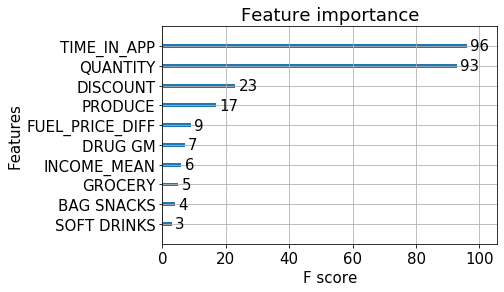

In [43]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

In [44]:
# fix leakage problem
#1
all_data['QUANTITY'] = all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)

# #2
all_data['DISCOUNT'] = all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)


all_data['TIME_IN_APP'] =  all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


# d['NUM_COUPONS'] = d.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['NUM_COUPONS'].shift(1)


In [45]:

training_data = all_data[all_columns]
training_data.isna().sum()

QUANTITY                      801
DISCOUNT                      801
AGE_MEAN                        0
HOUSEHOLD_SIZE                  0
NUM_ADULTS                      0
INCOME_MEAN                     0
NUM_CAMPAIGNS                   0
FUEL_PRICE_DIFF                 0
TIME_IN_APP                   801
NUM_COUPONS                     0
month_num                       0
month                           0
season                          0
DRUG GM                         0
GROCERY                         0
MEAT                            0
MEAT-PCKGD                      0
PRODUCE                         0
BAG SNACKS                      0
BAKED BREAD/BUNS/ROLLS          0
CHEESE                          0
FLUID MILK PRODUCTS             0
SOFT DRINKS                     0
days_since_last_shopping    11150
SALES_VALUE                     0
dtype: int64

In [46]:
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(70537, 38)


In [48]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:70.3797	train-rmse:62.1401
[1]	eval-rmse:65.4157	train-rmse:56.9685
[2]	eval-rmse:63.8727	train-rmse:55.2404
[3]	eval-rmse:63.0355	train-rmse:54.384
[4]	eval-rmse:63.1886	train-rmse:53.8783
[5]	eval-rmse:62.7625	train-rmse:53.2465
[6]	eval-rmse:62.4937	train-rmse:52.9483
[7]	eval-rmse:62.7308	train-rmse:52.6608
[8]	eval-rmse:62.8376	train-rmse:52.3667
[9]	eval-rmse:63.2562	train-rmse:52.0912
[10]	eval-rmse:63.6174	train-rmse:51.8994
[11]	eval-rmse:64.0976	train-rmse:51.7277
[12]	eval-rmse:64.0988	train-rmse:51.4638
[13]	eval-rmse:63.8739	train-rmse:51.2259
[14]	eval-rmse:64.315	train-rmse:51.1376


In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 44.4542617633816
mean squared error: 4136.431241035624
root mean squared error: 64.31509341543106
mean absolute percentage error: 64.31509341543106
R2: 0.29909077429222186


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


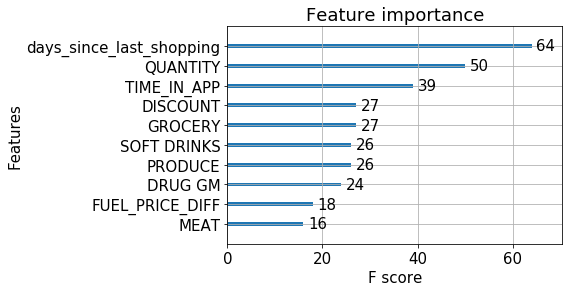

In [50]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

## Feature Engineering

In [52]:
all_data.shape

(81702, 29)

### 1. Amount spent on last shopping trip

In [96]:
spent_last_trip_df = transactions_weekly_aggregated.copy()
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['SALES_VALUE'].shift(1)

spent_last_trip_df = big_df.merge(spent_last_trip_df[['HOUSEHOLD_KEY','WEEK_NO','amount_spent_last_trip']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_trip_df.head()

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


In [97]:
def fill_nas_for_spent_trip(amount_spent_last_trip):

    new_column = []
    amount_spent_last_trip_column = amount_spent_last_trip.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(amount_spent_last_trip_column)):
        amount = amount_spent_last_trip_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=amount_spent_last_trip.index)


In [98]:
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df.groupby('HOUSEHOLD_KEY')['amount_spent_last_trip'].apply(fill_nas_for_spent_trip)


In [99]:
spent_last_trip_df.head()

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


### 2. Amount spent last week

In [100]:
spent_last_week_df = transactions_weekly_aggregated.copy()
spent_last_week_df = big_df.merge(spent_last_week_df[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_week_df['amount_spent_last_week'] = spent_last_week_df['SALES_VALUE'].shift(1)
spent_last_week_df['amount_spent_last_week'].fillna(0, inplace=True)
spent_last_week_df = spent_last_week_df[['WEEK_NO','HOUSEHOLD_KEY','amount_spent_last_week']]
spent_last_week_df.head()

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_week
0,1,1,0.0
1,2,1,0.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0


### 3. Number of weeks since last shopping

In [117]:
num_weeks_since_last_visit = transactions_weekly_aggregated.copy()
num_weeks_since_last_visit['last_shopping_week'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['WEEK_NO'].shift(1)
num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit['WEEK_NO']-num_weeks_since_last_visit['last_shopping_week']

num_weeks_since_last_visit = num_weeks_since_last_visit[['HOUSEHOLD_KEY','WEEK_NO','weeks_since_last_shopping']]



In [118]:
num_weeks_since_last_visit = big_df.merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
print(num_weeks_since_last_visit.shape)
num_weeks_since_last_visit.head()

(81702, 3)


,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


In [119]:
def fill_nas_for_last_week(weeks_since_shopping):

    new_column = []
    weeks_since_column = weeks_since_shopping.tolist()
#     print(weeks_since_column)
#     print(len(weeks_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(weeks_since_column)):
        num_weeks = 1
        value = weeks_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(weeks_since_column):
                next_day_since_value = weeks_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(weeks_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = weeks_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= num_weeks:
                    value = next_day_since_value-num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=weeks_since_shopping.index)


In [120]:

num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['weeks_since_last_shopping'].apply(fill_nas_for_last_week)



In [122]:
num_weeks_since_last_visit.head(10)

,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,0.0
8,9,1,1.0
9,10,1,2.0


### 4. average spent on previous shopping trips (with stats)

In [131]:
transactions_with_time = transactions_weekly_aggregated.copy()
print(transactions_with_time.shape)
transactions_with_time.head()



(56488, 5)


,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [144]:
mean = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean = mean.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean = mean.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean.index = mean['level_1']

mean = mean.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean = mean.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean['avg_spending_previous_trips'] = mean.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean = mean.drop('SALES_VALUE', axis=1)
# print(mean.shape)
# mean.head(100)

std = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std = std.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std = std.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std.index = std['level_1']

std = std.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std = std.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std['std_spending_previous_trips'] = std.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std = std.drop('SALES_VALUE', axis=1)
# print(std.shape)
# std.head(100)

var = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var = var.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var = var.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var.index = var['level_1']

var = var.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var = var.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var['var_spending_previous_trips'] = var.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var = var.drop('SALES_VALUE', axis=1)
# print(var.shape)
# var.head(100)

quan25 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25 = quan25.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25 = quan25.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25.index = quan25['level_1']

quan25 = quan25.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25 = quan25.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25['quan25_spending_previous_trips'] = quan25.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25 = quan25.drop('SALES_VALUE', axis=1)
# print(quan25.shape)
# quan25.head(100)

quan50 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50 = quan50.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50 = quan50.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50.index = quan50['level_1']

quan50 = quan50.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50 = quan50.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50['quan50_spending_previous_trips'] = quan50.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50 = quan50.drop('SALES_VALUE', axis=1)
# print(quan50.shape)
# quan50.head(100)

quan75 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75 = quan75.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75 = quan75.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75.index = quan75['level_1']

quan75 = quan75.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75 = quan75.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75['quan75_spending_previous_trips'] = quan75.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75 = quan75.drop('SALES_VALUE', axis=1)
# print(quan75.shape)
# quan75.head(100)

stats_prev_trips = big_df.merge(mean, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(std, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(var, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan25, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan50, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan75, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_trips.shape)
stats_prev_trips.head(10)


(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,78.66,NaN,NaN,78.66,78.66,78.66


In [145]:
def fill_nas_for_prev_trip(stats_column):

    new_column = []
    stats_column_list = stats_column.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(stats_column_list)):
        amount = stats_column_list[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=stats_column.index)


In [146]:
for column in stats_prev_trips:
    if column != 'WEEK_NO' or column != 'HOUSEHOLD_KEY':
        stats_prev_trips[column] = stats_prev_trips.groupby('HOUSEHOLD_KEY')[column].apply(fill_nas_for_prev_trip)


In [148]:
stats_prev_trips.head()

,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
stats_prev_trips.isna().sum()

WEEK_NO                               0
HOUSEHOLD_KEY                         0
avg_spending_previous_trips        9114
std_spending_previous_trips       10660
var_spending_previous_trips       10660
quan25_spending_previous_trips     9114
quan50_spending_previous_trips     9114
quan75_spending_previous_trips     9114
dtype: int64

5. average spent on previous weeks (with stats)

In [156]:
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
transactions_every_week.fillna(0, inplace=True)
transactions_every_week.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


In [163]:
mean_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean_r = mean_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean_r = mean_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean_r.index = mean_r['level_1']

mean_r = mean_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean_r = mean_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean_r['avg_spending_previous_weeks_real_time'] = mean_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean_r = mean_r.drop('SALES_VALUE', axis=1)
# print(mean_r.shape)
# mean_r.head(10)


std_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std_r = std_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std_r = std_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std_r.index = std_r['level_1']

std_r = std_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std_r = std_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std_r['std_spending_previous_weeks_real_time'] = std_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std_r = std_r.drop('SALES_VALUE', axis=1)
# print(std_r.shape)
# std_r.head()


var_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var_r = var_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var_r = var_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var_r.index = var_r['level_1']

var_r = var_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var_r = var_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var_r['var_spending_previous_weeks_real_time'] = var_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var_r = var_r.drop('SALES_VALUE', axis=1)
# print(var_r.shape)
# var_r.head(10)


quan25_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25_r = quan25_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25_r = quan25_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25_r.index = quan25_r['level_1']

quan25_r = quan25_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25_r = quan25_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25_r['quan25_spending_previous_weeks_real_time'] = quan25_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25_r = quan25_r.drop('SALES_VALUE', axis=1)
# print(quan25_r.shape)
# quan25_r.head(10)


quan50_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50_r = quan50_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50_r = quan50_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50_r.index = quan50_r['level_1']

quan50_r = quan50_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50_r = quan50_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50_r['quan50_spending_previous_weeks_real_time'] = quan50_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50_r = quan50_r.drop('SALES_VALUE', axis=1)
# print(quan50_r.shape)
# quan50_r.head(10)


quan75_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75_r = quan75_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75_r = quan75_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75_r.index = quan75_r['level_1']

quan75_r = quan75_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75_r = quan75_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75_r['quan75_spending_previous_weeks_real_time'] = quan75_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75_r = quan75_r.drop('SALES_VALUE', axis=1)
# print(quan75_r.shape)
# quan75_r.head(10)




In [164]:
stats_prev_weeks = big_df.merge(mean_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(std_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(var_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan25_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan50_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan75_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_weeks.shape)
stats_prev_weeks.head(10)

(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,0.0000,NaN,NaN,0.0,0.0,0.0
2,3,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
3,4,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
4,5,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
5,6,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
6,7,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
7,8,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
8,9,1,9.8325,27.81051,773.42445,0.0,0.0,0.0
9,10,1,8.7400,26.22000,687.48840,0.0,0.0,0.0


6. weighted mean of last 10 weeks' spendings

7. average visits per week

8. average visits per month

9. proportion of shopping weekdays and time of day